In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.manifold import TSNE

In [7]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_train = np.reshape(x_train, (60000,784))

x_test = np.expand_dims(x_test, -1)
x_test = np.reshape(x_test, (10000,784))
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 784)
60000 train samples
10000 test samples


In [ ]:
d = 30

class Autoencoder(keras.Model):
    
    def __init__(self,**kwargs):
        super(Autoencoder, self).__init__(**kwargs)
        
        self.Encoder = keras.Sequential(
            layers.Dense(d, activation="tanh"))
        
        self.Decoder = keras.Sequential(
            layers.Dense(28*28, activation="tanh"))
        
    def call(self, inputs):
        h = self.Encoder(inputs)
        out = self.Decoder(h)

        return out
    
    
    

model = Autoencoder()
model.compile(optimizer = "adam", loss = "mse")

from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='tanh', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [8]:
d = 30

encoder = keras.Sequential()
encoder.add(layers.Flatten(input_shape=(784,)))
encoder.add(layers.Dense(128, activation="tanh"))
encoder.add(layers.Dense(d, activation="tanh"))

decoder = keras.Sequential()
encoder.add(layers.Dense(128, activation="tanh"))
decoder.add(layers.Dense(784, activation="tanh"))

model = keras.Sequential()
model.add(encoder)
model.add(decoder)

model.compile(optimizer = "adam", loss = "mse")
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 128)               108318    
_________________________________________________________________
sequential_12 (Sequential)   (None, 784)               101136    
Total params: 209,454
Trainable params: 209,454
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(x_train, x_train, batch_size=128, epochs=10)

Epoch 1/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0321
Epoch 2/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0216
Epoch 3/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0211
Epoch 4/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0209
Epoch 5/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0208
Epoch 6/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0206
Epoch 7/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0203
Epoch 8/10
469/469 [==============================] - ETA: 0s - loss: 0.019 - 1s 3ms/step - loss: 0.0198
Epoch 9/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0192
Epoch 10/10
469/469 [==============================] - 1s 3ms/step - loss: 0.0185


In [10]:
new = model.predict(x_test)

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


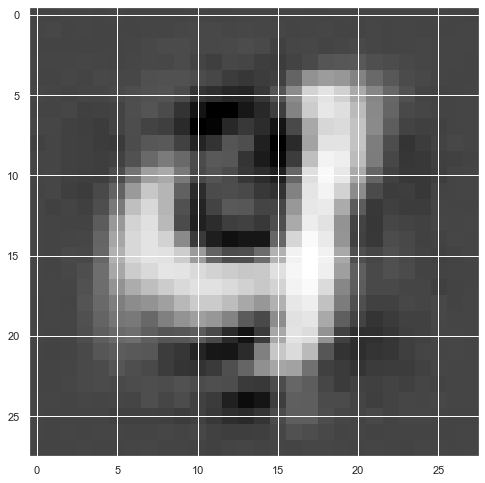

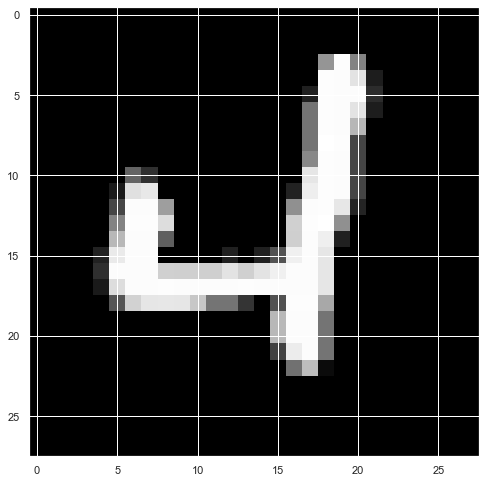

In [17]:
n = 399
print(y_test[n])

fig = plt.figure
plt.imshow(np.reshape(new[n], (28,28)), cmap='gray')
plt.show()

fig = plt.figure
plt.imshow(np.reshape(x_test[n], (28,28)), cmap='gray')
plt.show()

In [13]:
emb = encoder.predict(x_test)
X_embedded = TSNE(n_components=2).fit_transform(emb[:1000])

In [ ]:
emb_train = encoder.predict(x_train)
X_embedded_train = TSNE(n_components=2).fit_transform(emb_train[:10000])

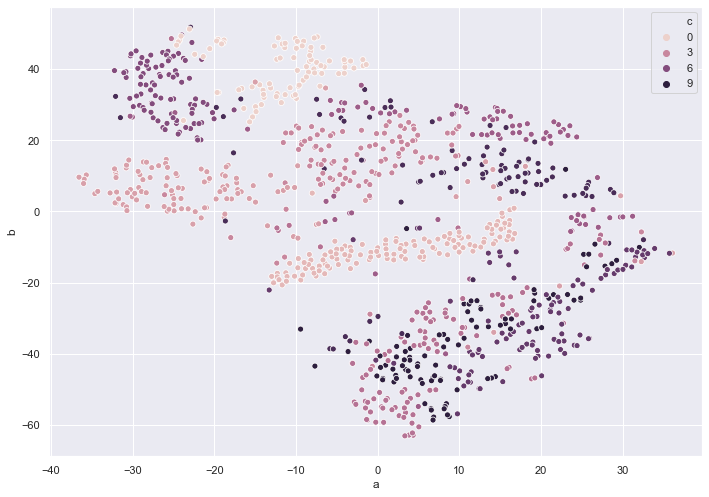

In [16]:
labels_clean = np.where(y_test==1)[1]
df = pd.DataFrame(data=X_embedded)
df[2] = labels_clean[:1000]
df.columns = ['a', 'b', 'c']
#df = df[df.c.isin([5,6,7,8])]

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(x='a', y='b', hue='c', data=df)